# Training a model on CarbonTracker's carbon flux
This notebook outlines the entire workflow to load and preprocess the following data sets, to be able to train a ML model:

- CarbonTracker
- ERA5 (monthly)
- ERA5-land (monthly)
- SPEI (monthly)
- MODIS (monthly)
- Biomass (yearly)

First follow the data downloading and config setup instuctions.

If you run this notebook on Surf Research Cloud, you shouldn't need to do this anymore.

We start by setting up a Dask client. This will ensure that Dask can run efficiently to process the data:

In [ ]:
from dask.distributed import Client
client = Client()

In [2]:
import excited_workflow
from pathlib import Path
import xarray as xr
import xarray_regrid  # Importing this will make Dataset.regrid accessible.

We will load the CarbonTracker data into an xarray `Dataset` and convert the timestamps (middle point of each month) to a more standard format (1st day of the month), to allow merging with the other datasets.

In [3]:
ds_cb = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/CT2022.flux1x1-monthly.nc")
ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)

The other datasets can be found using the excited_workflow.source_datasets module:

In [4]:
from excited_workflow.source_datasets import datasets
datasets

{'biomass': excited_workflow.source_datasets.biomass.Biomass,
 'era5_hourly': excited_workflow.source_datasets.era5.ERA5Hourly,
 'era5_monthly': excited_workflow.source_datasets.era5.ERA5Monthly,
 'era5_land_monthly': excited_workflow.source_datasets.era5.ERA5LandMonthly,
 'copernicus_landcover': excited_workflow.source_datasets.land_cover.LandCover,
 'modis': excited_workflow.source_datasets.modis.Modis,
 'spei': excited_workflow.source_datasets.spei.Spei}

We can loop over the desired datasets and merge them into a single xr.Dataset:

In [5]:
desired_data = [
    "biomass",
    "spei",
    "modis",
    "era5_monthly",
    "era5_land_monthly"
]
ds_input = xr.merge(
    [datasets[name].load(freq="monthly", target_grid=ds_cb) for name in desired_data]
)

To limit the analyis to Transcom region 2 (North America) we require the `regions.nc` file:

In [6]:
ds_regions = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/regions.nc")
# Uncomment the next line to preview the region:
#ds_regions["transcom_regions"].where(ds_regions["transcom_regions"]==2).plot()

Now we can merge everything together. From the CarbonTracker file we only require the `bio_flux_opt` variable:

In [7]:
ds_merged = xr.merge([
    ds_cb[["bio_flux_opt"]], 
    ds_regions["transcom_regions"],
    ds_input,
])

To make computations faster and less memory intensive, we can reduce the scope to only North America.

This `.sel` operation reduces the size of the dataset from worldwide to only a rectangular area around North America:

In [8]:
time_region_na = {
    "time": slice("2010-01", "2019-12"),
    "latitude": slice(15, 60),
    "longitude": slice(-140, -55),
}
ds_na = ds_merged.sel(time_region_na)

In [9]:
ds_na = ds_na.compute()

From this North American dataset we can mask the transcom region, and preview the 2m air temperature of ERA5:

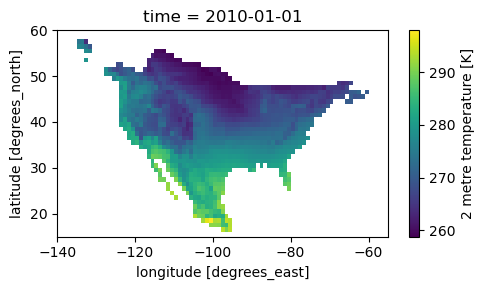

In [10]:
ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
ds_na["t2m"].isel(time=0).plot()
plt.tight_layout()

To prepare the data for training, we convert it to a Pandas `DataFrame`.

In [11]:
df_train = ds_na.to_dataframe().dropna()
df_train.columns

Index(['bio_flux_opt', 'transcom_regions', 'biomass', 'spei', 'NDVI', 'NIRv',
       'd2m', 'mslhf', 'msshf', 'sp', 'ssr', 'str', 't2m', 'tp', 'tvh', 'tvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'swvl1', 'swvl2', 'swvl3',
       'swvl4'],
      dtype='object')

Now we can our ML models on the data. Here we use pycaret to try a set of models and see which type performs best.

In [12]:
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)
best = pycs.compare_models(n_select=5, round=2)

,Description,Value
0,Session id,4529
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(13728, 12)"
4,Transformed data shape,"(13728, 12)"
5,Transformed train set shape,"(9609, 12)"
6,Transformed test set shape,"(4119, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.34,0.26,0.51,0.76,0.23,3.88,0.83
rf,Random Forest Regressor,0.34,0.26,0.51,0.75,0.24,3.99,2.41
catboost,CatBoost Regressor,0.34,0.26,0.51,0.75,0.24,4.34,2.78
lightgbm,Light Gradient Boosting Machine,0.34,0.26,0.51,0.75,0.24,4.12,0.20
xgboost,Extreme Gradient Boosting,0.36,0.28,0.53,0.73,0.25,4.76,0.48
gbr,Gradient Boosting Regressor,0.36,0.29,0.54,0.72,0.25,4.74,1.18
ridge,Ridge Regression,0.46,0.42,0.65,0.60,0.30,6.46,0.02
br,Bayesian Ridge,0.46,0.42,0.65,0.60,0.30,6.45,0.03
ada,AdaBoost Regressor,0.50,0.45,0.67,0.57,0.32,7.97,0.32
lar,Least Angle Regression,0.49,0.47,0.68,0.56,0.31,7.32,0.02


Using pycaret, the trained models can be evaluated.

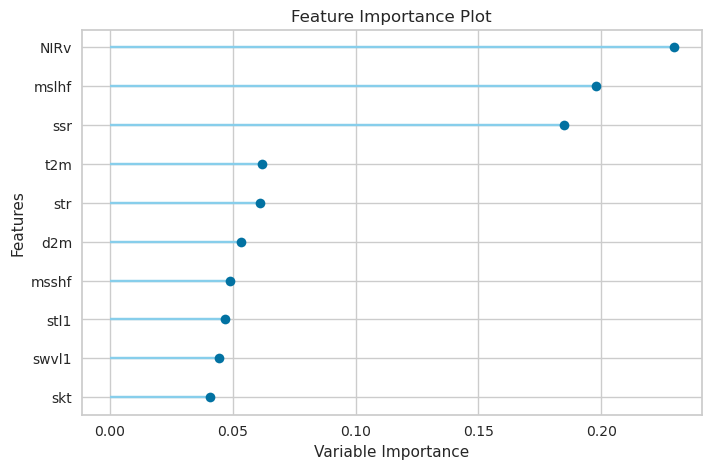

2023-11-14 13:40:32,734 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


In [14]:
pycs.plot_model(best[0], plot="feature")

By including biomass info, we get a slightly better model performance.

In [15]:
X_keys = ["biomass", "d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)
best = pycs.compare_models(round=2)

,Description,Value
0,Session id,8532
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(13728, 13)"
4,Transformed data shape,"(13728, 13)"
5,Transformed train set shape,"(9609, 13)"
6,Transformed test set shape,"(4119, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.33,0.24,0.49,0.77,0.23,3.47,0.90
catboost,CatBoost Regressor,0.33,0.24,0.49,0.77,0.23,4.09,2.85
lightgbm,Light Gradient Boosting Machine,0.33,0.25,0.50,0.76,0.23,4.26,0.10
rf,Random Forest Regressor,0.33,0.25,0.50,0.76,0.23,3.91,2.59
gbr,Gradient Boosting Regressor,0.36,0.28,0.53,0.74,0.24,5.56,1.22
xgboost,Extreme Gradient Boosting,0.35,0.27,0.52,0.74,0.24,4.23,0.51
ridge,Ridge Regression,0.45,0.41,0.64,0.61,0.29,7.82,0.03
br,Bayesian Ridge,0.47,0.43,0.65,0.59,0.30,8.81,0.03
ada,AdaBoost Regressor,0.49,0.45,0.67,0.58,0.32,7.38,0.33
lar,Least Angle Regression,0.52,0.50,0.71,0.52,0.32,9.37,0.02


2023-11-14 13:40:59,737 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-11-14 13:41:00,309 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-14 13:41:00,937 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-11-14 13:41:01,485 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-14 13:41:02,031 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-11-14 13:41:02,540 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-11-14 13:41:03,125 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-11-14 13:41:03,690 - distributed.utils_perf - WARNING - full garbage collections took

However, in the feature importance plot you can see that the importance of NIRv is now reduced by including biomass info:

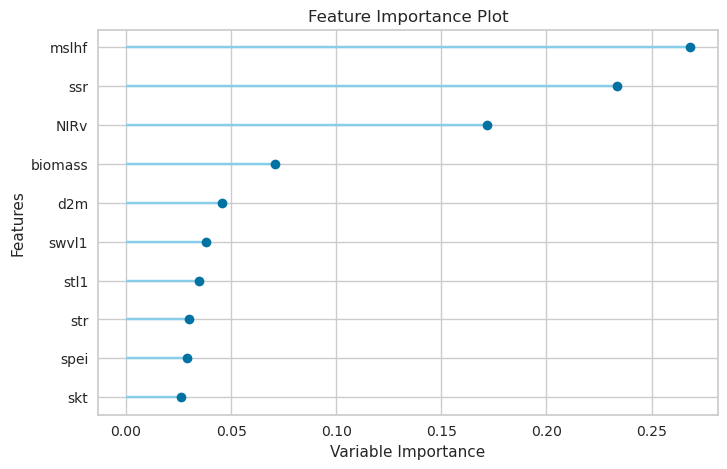

2023-11-14 13:42:36,489 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


In [16]:
pycs.plot_model(best[0], plot="feature")

However, this feature imporance depends on the model used. For a different well performing model, the feature imporance is the following:

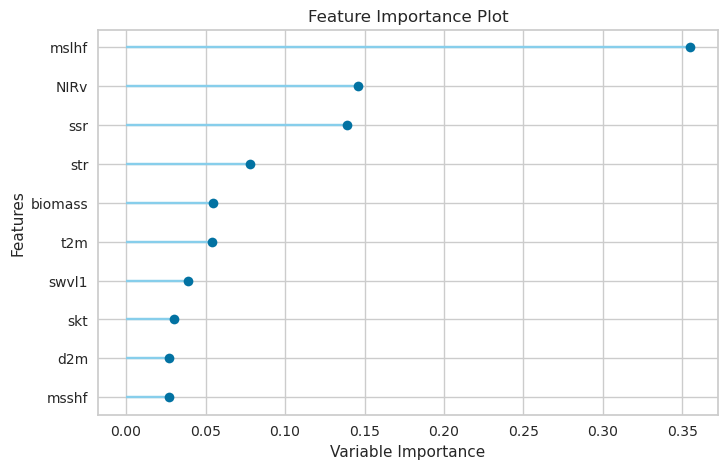

2023-11-14 13:50:37,477 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


In [18]:
pycs.plot_model(best[3], plot="feature")